In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
plt.rcParams.update({'font.size': 18})
plt.style.use('vedant')
import sys
sys.path.append('../../WD_models/')
from sed_fitter import FitSED
from tqdm import tqdm
from scipy import stats

In [2]:
import P4J
#import recombinator
import astropy.units as u
import pandas as pd

In [3]:
def get_mean_flux(t, flux, e_flux, gap = 10, plot = False):
        
    sortidx = np.argsort(t)
    t = t[sortidx]
    flux = flux[sortidx]
    e_flux = e_flux[sortidx]
    
    e_flux[np.isnan(e_flux)] = np.nanmax(e_flux)
    
    fi = np.where(abs(np.diff(t)) > gap)[0]

    fi = np.concatenate(([-1], fi))

    sm_pt = 0

    mean_times = [];
    mean_flux = [];
    e_mean_flux = [];

    flux_arr = [];
    e_flux_arr = [];
    t_arr = [];
    for kk in range(len(fi)):

        idx1 = fi[kk] + 1
        if kk < len(fi)-1:
            idx2 = fi[kk + 1] + 1
        elif kk == len(fi)-1:
            idx2 = None

        t_i = t[idx1:idx2]
        flux_i = flux[idx1:idx2]
        e_flux_i = e_flux[idx1:idx2]

        sm_pt += len(t_i)
        
        if plot:

            plt.figure()
            plt.plot(t_i, flux_i, 'ko')
            plt.show()

        t_arr.append(t_i)
        flux_arr.append(flux_i)

        mean_times.append(np.mean(t_i))
        mean_flux.append(np.average(flux_i, weights = (1 / e_flux_i)**2))
        e_mean_flux.append(np.median(e_flux_i) / np.sqrt(len(t_i)) + stats.sem(flux_i))

    meanlc = lk.LightCurve(time = mean_times, flux = mean_flux, flux_err = e_mean_flux)
    
    return meanlc

# WISE Light Curve

In [4]:
allwise = pd.read_csv('wise_data/d62_allwise.csv')
neowiseR = pd.read_csv('wise_data/d62_neowise_R.csv')

neo_clean = (
    (neowiseR['ra'] > 324.6117)&
    (neowiseR['ra'] < 324.6133)&
    (neowiseR['w1sigmpro'] < 0.3)&
    (neowiseR['w1rchi2'] < 1.5)&
    (neowiseR['w1snr'] > 3)&
    (neowiseR['w1sigmpro'] > 0)

)

print(len(allwise))

print(len(neowiseR))
print(len(neowiseR[neo_clean]))

neowiseR = neowiseR[neo_clean]

27
178
141


In [5]:
allwise_mjd = np.array(allwise['mjd'])
allwise_mags = np.array(allwise['w1mpro_ep'])
e_allwise_mags = np.array(allwise['w1sigmpro_ep'])
allwise_mags2 = np.array(allwise['w2mpro_ep'])
e_allwise_mags2 = np.array(allwise['w2sigmpro_ep'])

neowiseR_mjd = np.array(neowiseR['mjd'])
neowiseR_mags = np.array(neowiseR['w1mpro'])
e_neowiseR_mags = np.array(neowiseR['w1sigmpro'])
neowiseR_mags2 = np.array(neowiseR['w2mpro'])
e_neowiseR_mags2 = np.array(neowiseR['w2sigmpro'])

mjd = np.concatenate((allwise_mjd, neowiseR_mjd))

mags = np.concatenate((allwise_mags, neowiseR_mags))
e_mags = np.concatenate((e_allwise_mags, e_neowiseR_mags))

mags2 = np.concatenate((allwise_mags2, neowiseR_mags2))
e_mags2 = np.concatenate((e_allwise_mags2, e_neowiseR_mags2))
e_mags2[np.isnan(e_mags2)] = np.nanmax(e_mags2)

In [6]:
len(mags)

168

In [7]:
lc1_raw = lk.LightCurve(mjd, mags, e_mags)
lc2_raw = lk.LightCurve(mjd, mags2, e_mags2)

lc1 = get_mean_flux(mjd, mags, e_mags, gap = 10);
lc2 = get_mean_flux(mjd, mags2, e_mags2, gap = 10);

mean_times = lc1.time

/Users/vedantchandra/opt/anaconda3/envs/d62/lib/python3.8/site-packages/lightkurve/lightcurve.py:205: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


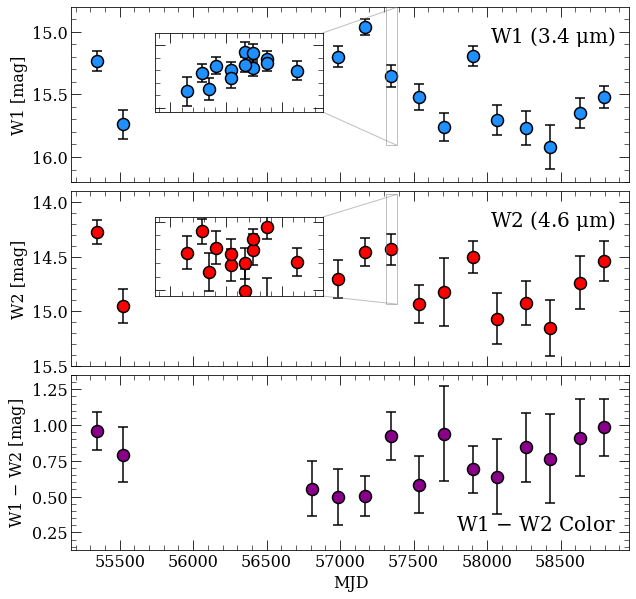

In [8]:
plt.figure(figsize = (10, 10))

plt.subplot(311)

kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'dodgerblue', capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

plt.errorbar(lc1.time.value, lc1.flux.value, yerr = lc1.flux_err.value, **kwargs)
plt.text(0.975, 0.9, 'W1 (3.4 $\mu$m)', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.gca().set_xticklabels([])
plt.ylabel('W1 [mag]')
plt.ylim(14.8, 16.2)
plt.gca().invert_yaxis()

ax = plt.gca()
axins = ax.inset_axes([0.15, 0.4, 0.3, 0.45])
axins.errorbar(mjd, mags, yerr = e_mags, **kwargs)
# sub region of the original image
jj = 5
dm = 0.55
x1, x2, y1, y2 = lc1.time[jj].value - 35, lc1.time[jj].value + 35, lc1.flux[jj].value - dm, lc1.flux[jj].value + dm
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins)
axins.set_ylim(lc1.flux[jj].value - dm, lc1.flux[jj].value + 1.3*dm)
axins.set_xlim(lc1.time[jj].value - .5, lc1.time[jj].value + 1)
axins.invert_yaxis()


plt.subplot(312)

kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'red', capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

plt.errorbar(lc2.time.value, lc2.flux.value, yerr = lc2.flux_err.value, **kwargs)
plt.gca().set_xticklabels([])
plt.ylabel('W2 [mag]')
plt.text(0.975, 0.9, 'W2 (4.6 $\mu$m)', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.ylim(13.9, 15.5)
plt.gca().invert_yaxis()

ax = plt.gca()
axins = ax.inset_axes([0.15, 0.4, 0.3, 0.45])
axins.errorbar(mjd, mags2, yerr = e_mags2, **kwargs)
# sub region of the original image
# jj = 5
# dm = 0.55
dm = 0.5
x1, x2, y1, y2 = lc2.time[jj].value - 35, lc2.time[jj].value + 35, lc2.flux[jj].value - dm, lc2.flux[jj].value + dm
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')
ax.indicate_inset_zoom(axins)
axins.set_ylim(lc2.flux[jj].value - dm, lc2.flux[jj].value + 1.3*dm)
axins.set_xlim(lc2.time[jj].value - .5, lc2.time[jj].value + 1)
axins.invert_yaxis()

plt.subplot(313)


kwargs = dict(linestyle = 'none', marker = 'o', ecolor = 'k', color = 'darkmagenta', 
              capsize = 5, linewidth = 1.5,
             mec = 'k', mew = 1.5, markersize = 12)

ratio = lc1.flux.value - lc2.flux.value
error = np.sqrt(lc1.flux_err.value**2 + lc2.flux_err.value**2)#ratio * np.sqrt((e_mean_fls / mean_fls)**2 + (e_mean_fls2/mean_fls2)**2)
plt.errorbar(lc2.time.value, ratio, yerr = error,**kwargs)
plt.text(0.975, 0.2, 'W1 $-$ W2 Color', ha = 'right', va = 'top', transform = plt.gca().transAxes, fontsize = 20)
plt.ylim(0.125, 1.35)

plt.xlabel('MJD')
plt.ylabel('W1 $-$ W2 [mag]')
plt.subplots_adjust(hspace = 0.05)

plt.savefig('fig/jwst_lc.pdf', bbox_inches = 'tight')

In [9]:
fitsed = FitSED(bands = ['W1'])
fitsed2 = FitSED(bands = ['W2'])

initialized with atm_type = H and bands = ['W1']
initialized with atm_type = H and bands = ['W2']


### Temperature Variation

In [10]:
import astropy.constants as c

In [11]:
stellar_model =  np.loadtxt('txt/stellar_model.txt')
wls = np.loadtxt('txt/wls.txt')
bestfit = np.loadtxt('txt/bestfit.txt')

mjd = lc1.time.value

flux1 = np.array([fitsed.mag_to_flux([lc1.flux.value[ii]]) for ii in range(len(lc1.flux))]).ravel()

flux1 -= stellar_model[-2]

e_flux1 = lc1.flux_err.value * flux1

flux2 = np.array([fitsed.mag_to_flux([lc2.flux.value[ii]]) for ii in range(len(lc2.flux))]).ravel()

flux2 -= stellar_model[-1]

e_flux2 = lc2.flux_err.value * flux2

In [12]:
def bb_model(wl, T, R):
    
    R = R * c.R_sun
    D = (1000 / bestfit[2]) * c.pc
    
    nu = c.c / (wl * 1e-10 * u.m)
    
    sa = np.pi * R**2 / D**2
    
    t1 = 2 * c.h * nu**3 / c.c**2
    t2 = np.exp(c.h * nu / (c.k_B * T * u.K)) - 1
    
    return (sa * t1 / t2).to(u.Jy).value

In [13]:
p0 = [1000, 14]

In [14]:
def rob_std(array):
    return (np.quantile(array, 0.84) - np.quantile(array, 0.16))/2

100%|██████████| 14/14 [00:33<00:00,  2.38s/it]


Text(0, 0.5, 'Flux')

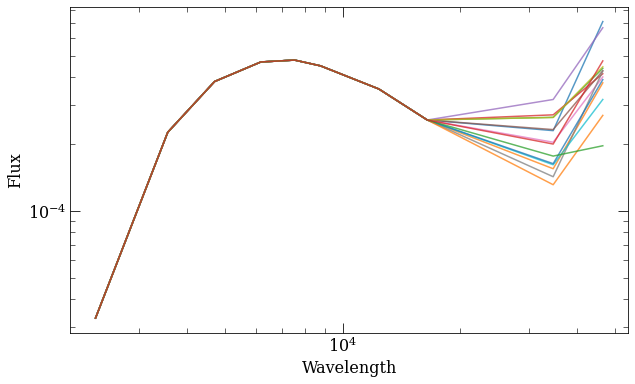

In [15]:
T = [];
e_T = [];

R = [];
e_R = [];

nmc = 100

plt.figure(figsize = (10, 6))

for ii in tqdm(range(len(flux1))):
    Ti = [];
    Ri = [];
    for n in range(nmc):
        
        
        sed = np.array([flux1[ii], flux2[ii]])
        sed += np.array([e_flux1[ii] * np.random.normal(), e_flux2[ii] * np.random.normal()])
        
        sed = np.concatenate((np.repeat(0, len(stellar_model) - 2), sed)) # add star fluxes
        
        if n == 0:
            plt.plot(wls, stellar_model + sed, lw = 1.5, alpha = 0.75)
        
        #plt.plot(wls, sed)
        #break
        
        p,cov = scipy.optimize.curve_fit(bb_model, wls, sed, p0 = p0)
        
        Ti.append(p[0])
        Ri.append(p[1])
        
    T.append(np.mean(Ti))
    e_T.append(rob_std(Ti))
    
    R.append(np.mean(Ri))
    e_R.append(rob_std(Ri))
    
T = np.array(T)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Wavelength')
plt.ylabel('Flux')

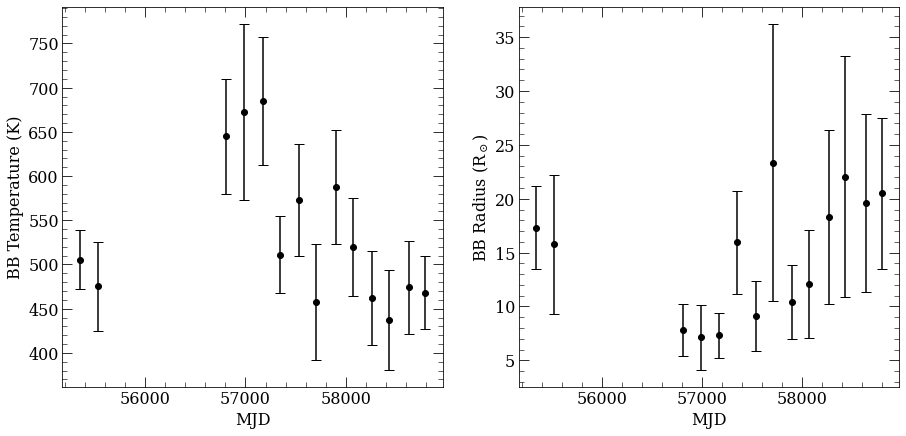

In [16]:
plt.figure(figsize = (15, 7))

kw = dict(linestyle = 'none', marker = 'o', capsize = 5, color = 'k')

plt.subplot(121)
plt.errorbar(mjd, T, yerr = e_T, **kw)
plt.xlabel('MJD')
plt.ylabel('BB Temperature (K)')

plt.subplot(122)
plt.errorbar(mjd, R, yerr = e_R, **kw)

plt.xlabel('MJD')
plt.ylabel('BB Radius (R$_\odot$)')

plt.savefig('fig/bbfit_wise.pdf', bbox_inches = 'tight')

In [17]:
def Rin_bb(Tin, Rstar, Tstar):
    return (Rstar / 2) * (Tstar / Tin)**(2)

def Rin_rayl(Tin, Rstar, Tstar):
    return (Rstar / 2) * (Tstar / Tin)**(5/2)

0.42114949899474124
0.5089863032924027


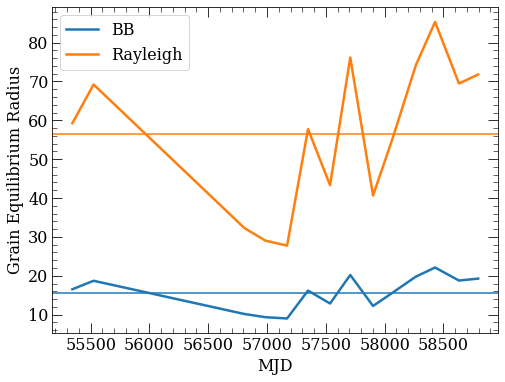

In [18]:
Rstar = 0.2
Tstar = 6500

Rins = Rin_bb(T, Rstar, Tstar)
plt.plot(mjd, Rins, lw = 2.5, label = 'BB')
apo = np.max(Rins)
peri = np.min(Rins)
a = (apo + peri)/2
b = np.sqrt(apo * peri)
e = np.sqrt(1 - (b**2 / a**2))
print(e)
plt.axhline(a)

Rins = Rin_rayl(T, Rstar, Tstar)
plt.plot(mjd, Rins, lw = 2.5, label = 'Rayleigh')
apo = np.max(Rins)
peri = np.min(Rins)
a = (apo + peri)/2
b = np.sqrt(apo * peri)
e = np.sqrt(1 - (b**2 / a**2))
print(e)
plt.axhline(a, color = 'C1')


plt.xlabel("MJD")
plt.ylabel("Grain Equilibrium Radius")

plt.legend()

### WISE ASTROMETRY

81
178
81


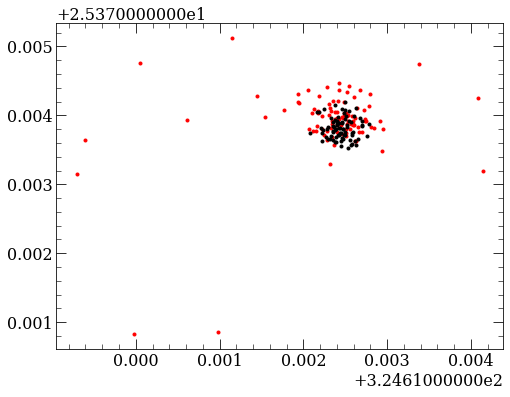

In [23]:
import pandas as pd
from ltsfit.lts_linefit import lts_linefit

wise = pd.read_csv('wise_data/d62_neowise_R.csv')

clean = (
    (wise['sigra'] < 0.5)&
    (wise['sigdec'] < 0.5)&
    (wise['dec'] > 25.3735) &
    (wise['dec'] < 25.3742) & 
    (wise['ra'] < 324.6128)

)

# for nearby:

# clean = (
#     (wise['sigra'] < 0.7)&
#     (wise['sigdec'] < 0.7)&
#     (wise['dec'] > 25.3735) & 
#     (wise['ra'] < 324.6128) &
#     (wise['dec'] > 25.37857)

# )
print(np.sum(clean))
print(len(wise))

plt.plot(wise['ra'][~clean], wise['dec'][~clean], 'r.')
plt.plot(wise['ra'][clean], wise['dec'][clean], 'k.')

wise = wise[clean]
print(len(wise))

In [24]:
allwise_ra = allwise['ra'][0]
allwise_dec = allwise['dec'][0]

In [25]:
allwise_ra

324.6123064

In [26]:
def arrowplot(axes, x, y, narrs=30, dspace=0.5, direc='pos', \
                          hl=0.3, hw=6, fc='black', ec = 'black'): 
    ''' narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head 

        hw     :  width of the arrow head        

        c      :  color of the edge and face of the arrow head  
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1] 
        dy = y[i]-y[i-1] 
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace) 
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1 
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]: 
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    # could be done in above block if you want
    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2. + ax
        dy0 = np.cos(theta)*hl/2. + ay
        dx1 = -1.*np.sin(theta)*hl/2. + ax
        dy1 = -1.*np.cos(theta)*hl/2. + ay

        if direc is 'neg' :
          ax0 = dx0 
          ay0 = dy0
          ax1 = dx1
          ay1 = dy1 
        else:
          ax0 = dx1 
          ay0 = dy1
          ax1 = dx0
          ay1 = dy0 

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=ec, fc=fc), zorder = 0)


    axes.plot(x,y, color = ec, zorder = 0)
    axes.set_xlim(x.min()*.9,x.max()*1.1)
    axes.set_ylim(y.min()*.9,y.max()*1.1)

<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-26-f08a574aebce>:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg':
<ipython-input-26-f08a574aebce>:71: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direc is 'neg' :


In [27]:
ara = ((allwise_ra)* u.degree).to(u.milliarcsecond).value
adec = ((allwise_dec)* u.degree).to(u.milliarcsecond).value

sig_int:     0.0000      0.4998
Computing sig_int
sig_int:     0.0000      0.4998
sig_int:   584.2388     -0.5628
sig_int:   274.8101     -0.0320
sig_int:   258.2753      0.0084
sig_int:   261.7046     -0.0001
sig_int:   261.5738      0.0002
Computing sig_int error
sig_int:   261.7046      0.1600
sig_int:   584.2388     -0.4026
sig_int:   353.4478      0.0037
sig_int:   355.6232     -0.0011
sig_int:   355.1182     -0.0000
sig_int:   354.9406      0.0004
Repeat at best fitting solution
sig_int:   261.7046     -0.0001
################# Values and formal errors ################
 intercept:  470. +/- 51.
     slope:  92. +/- 33.
   scatter:  262. +/- 93.
Observed rms scatter: 4.7e+02
y = a + b*(x - pivot) with pivot = 1.471
Spearman r=0.31 and p=0.0055
Pearson r=0.28 and p=0.01
##########################################################
seconds 6.47
92.3557366396132 marcsec / yr


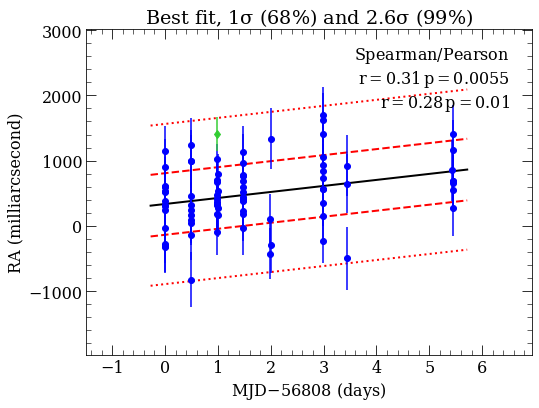

In [28]:
x = (np.array(wise['mjd'] - np.min(wise['mjd'])) * u.day).to(u.year).value
y = (np.array(wise['ra']) * u.degree).to(u.milliarcsecond).value

y = y - ara

e_x = (np.array(np.repeat(0, len(x))) * u.day).to(u.year).value
e_y = (np.array(wise['sigra']) * u.arcsecond).to(u.milliarcsecond).value

plt.clf()
p = lts_linefit(x, y, e_x, e_y, pivot = np.median(x), text = False)
plt.xlabel('MJD$-%i$ (days)' % wise['mjd'].min())
plt.ylabel('RA (milliarcsecond)')
xgap = 1.5
plt.xlim(x.min() - xgap, x.max() + xgap)
ygap = 2500
plt.ylim(np.median(y) - ygap, np.median(y) + ygap)
delta_deg = p.ab[1] * u.milliarcsecond / u.year ## degrees per day

print(delta_deg)

pra = p.ab
e_pra = p.ab_err

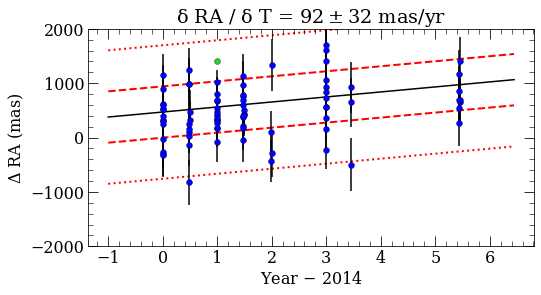

In [29]:
plt.figure(figsize = (8, 4))

plt.errorbar(x[p.mask], y[p.mask], xerr = e_x[p.mask], yerr = e_y[p.mask], mfc = 'blue', 
             linestyle = 'none', 
                mec = 'k', mew = 0.3, marker = 'o', ecolor = 'k', capsize = 0)

plt.errorbar(x[~p.mask], y[~p.mask], color = 'LimeGreen', 
             linestyle = 'none', 
            mec = 'k', mew = 0.3, marker = 'o')

xmin, xmax = x.min(), x.max()
xgap = 1
xlimits = np.linspace(xmin - xgap, xmax + xgap)

plt.plot(xlimits, p.ab[0] + p.ab[1] * xlimits, 'k')

plt.plot(xlimits, p.rms + p.ab[0] + p.ab[1] * xlimits, 'r--',
         xlimits, p.ab[0] + p.ab[1] * xlimits - p.rms, 'r--',
        xlimits, 2.6*p.rms + p.ab[0] + p.ab[1] * xlimits, 'r:',
        xlimits, p.ab[0] + p.ab[1] * xlimits - 2.6*p.rms, 'r:',
        lw = 2, zorder = 1)

plt.ylim(-2000, 2000)
plt.xlabel('Year $-$ 2014')
plt.ylabel('$\Delta$ RA (mas)')
plt.title('$\delta$ RA / $\delta$ T = $%i \pm %i$ mas/yr' % (p.ab[1], p.ab_err[1]))

plt.savefig('fig/wise_pmra.pdf', bbox_inches = 'tight')

sig_int:     0.0000     -0.1478
No intrinsic scatter or errors overestimated
Repeat at best fitting solution
sig_int:     0.0000     -0.1478
################# Values and formal errors ################
 intercept:  1244. +/- 41.
     slope:  253. +/- 27.
   scatter:  0. +/- 0.0
Observed rms scatter: 3.5e+02
y = a + b*(x - pivot) with pivot = 1.471
Spearman r=0.66 and p=1.4e-11
Pearson r=0.72 and p=3.8e-14
##########################################################
seconds 0.86
253.01157836508406 marcsec / yr


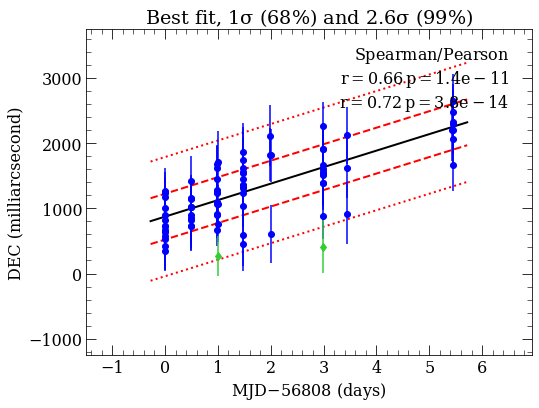

In [30]:
x = (np.array(wise['mjd'] - np.min(wise['mjd'])) * u.day).to(u.year).value
y = (np.array(wise['dec']) * u.degree).to(u.milliarcsecond).value

y = y - adec

e_x = (np.array(np.repeat(0, len(x))) * u.day).to(u.year).value
e_y = (np.array(wise['sigdec']) * u.arcsecond).to(u.milliarcsecond).value

plt.clf()
p = lts_linefit(x, y, e_x, e_y, pivot = np.median(x), text = False)
plt.xlabel('MJD$-%i$ (days)' % wise['mjd'].min())
plt.ylabel('DEC (milliarcsecond)')
xgap = 1.5
plt.xlim(x.min() - xgap, x.max() + xgap)
ygap = 2500
plt.ylim(np.median(y) - ygap, np.median(y) + ygap)
delta_deg = p.ab[1] * u.milliarcsecond / u.year ## degrees per day

print(delta_deg)
pdec = p.ab
e_pdec = p.ab_err

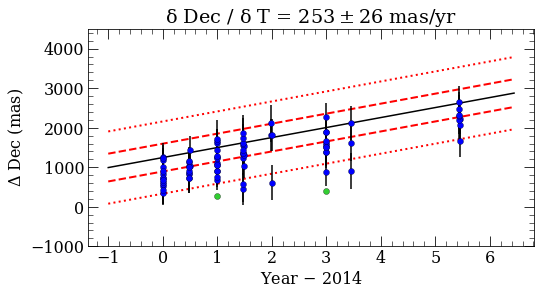

In [31]:
plt.figure(figsize = (8, 4))

plt.errorbar(x[p.mask], y[p.mask], xerr = e_x[p.mask], yerr = e_y[p.mask], mfc = 'blue', 
             linestyle = 'none', 
                mec = 'k', mew = 0.3, marker = 'o', ecolor = 'k', capsize = 0)

plt.errorbar(x[~p.mask], y[~p.mask], color = 'LimeGreen', 
             linestyle = 'none', 
            mec = 'k', mew = 0.3, marker = 'o')

xmin, xmax = x.min(), x.max()
xgap = 1
xlimits = np.linspace(xmin - xgap, xmax + xgap)

plt.plot(xlimits, p.ab[0] + p.ab[1] * xlimits, 'k')

plt.plot(xlimits, p.rms + p.ab[0] + p.ab[1] * xlimits, 'r--',
         xlimits, p.ab[0] + p.ab[1] * xlimits - p.rms, 'r--',
        xlimits, 2.6*p.rms + p.ab[0] + p.ab[1] * xlimits, 'r:',
        xlimits, p.ab[0] + p.ab[1] * xlimits - 2.6*p.rms, 'r:',
        lw = 2, zorder = 1)

plt.ylim(-1000, 4500)
plt.xlabel('Year $-$ 2014')
plt.ylabel('$\Delta$ Dec (mas)')
plt.title('$\delta$ Dec / $\delta$ T = $%i \pm %i$ mas/yr' % (p.ab[1], p.ab_err[1]));

plt.savefig('fig/wise_pmdec.pdf', bbox_inches = 'tight')

In [32]:
import matplotlib
cmap = matplotlib.cm.get_cmap('coolwarm')

In [33]:
cosdec = np.cos(wise['dec'] * np.pi / 180)

In [34]:
from scipy.stats import binned_statistic

In [35]:
def prop_mean_error(x):
    x = np.array(x)
    return np.sqrt(np.sum(x**2)) / len(x)

In [42]:
ara = ((allwise_ra)* u.degree).to(u.milliarcsecond).value
adec = ((allwise_dec)* u.degree).to(u.milliarcsecond).value

In [73]:
gaia_pmra = 98 / 1000
gaia_pmdec = 240 / 1000
years = 1

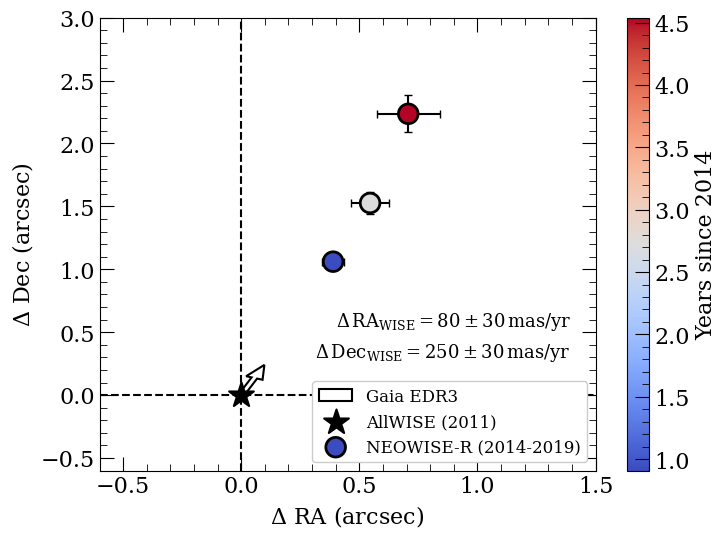

In [95]:
plt.figure(figsize = (8, 6), dpi = 100)

for yr in range(years):
    plt.arrow(0 + gaia_pmra*yr, 0 + gaia_pmdec * yr, gaia_pmra*1, gaia_pmdec*1, width = 0.025,
             length_includes_head = True, color = 'w', lw = 1.5, ec = 'k', zorder = 0,
             label = r'Gaia EDR3')

t = (np.array(wise['mjd']) - np.min(np.array(wise['mjd']))) / 365

x = (np.array(wise['ra']) * u.degree).to(u.milliarcsecond).value
x = (x - ara) * cosdec # MULTIPLY BY COS DEC
e_x = (np.array(wise['sigra'] * cosdec) * u.arcsecond).to(u.milliarcsecond).value

y = (np.array(wise['dec']) * u.degree).to(u.milliarcsecond).value
y = y - adec
e_y = (np.array(wise['sigdec']) * u.arcsecond).to(u.milliarcsecond).value

## BIN

nbin = 3
bsx = binned_statistic(t, x, bins = nbin)
nb = int(len(t)/nbin)
x = bsx.statistic
e_x =  binned_statistic(t, e_x, bins = bsx.bin_edges, statistic = prop_mean_error).statistic
y =  binned_statistic(t, y, bins = bsx.bin_edges).statistic
e_y =  binned_statistic(t, e_y, bins = bsx.bin_edges, statistic = prop_mean_error).statistic
t = bsx.bin_edges[0:-1] + np.diff(bsx.bin_edges)[0]/2

plt.scatter(0, 0,
            marker = '*', edgecolor = 'k', s = 350, linewidth = 1.5, 
               color = 'k', label = 'AllWISE (2011)', alpha = 1)

plt.scatter(x/1000, y/1000, c = t, cmap = 'coolwarm',
            marker = 'o', edgecolor = 'k', linewidth = 2, s = 200, label = 'NEOWISE-R (2014-2019)',
            alpha = 1,
           )

plt.errorbar(x/1000, y/1000, xerr = e_x/1000, yerr = e_y/1000, linestyle = 'none',
             capsize = 3, zorder = 0, color = 'k'
)
plt.axvline(0, color = 'k', linestyle = '--', zorder = 0)
plt.axhline(0, color = 'k', linestyle = '--', zorder = 0)


cbar = plt.colorbar()
cbar.ax.set_ylabel('Years since 2014')
plt.xlabel('$\Delta$ RA (arcsec)')
plt.ylabel('$\Delta$ Dec (arcsec)')

tgrid = np.linspace(-25, 25)
ragrid = tgrid * pra[1] + 0
decgrid = tgrid * pdec[1] + 0

ax = plt.gca()

# arrowplot(ax, ragrid/1000, decgrid/1000, direc = 'neg', hl = 0.6, hw = 7, 
#           narrs = 10, dspace = 0.6, ec = 'black', fc = 'red')

edge = 3
plt.ylim(-edge+2.4, edge)
plt.xlim(-edge+2.4, edge-1.5)

plt.text(0.95, 0.32, '$\Delta\,{RA_{WISE}} = %i \pm %i\, mas/yr$' % (round(pra[1] * np.mean(cosdec), -1), 
                                                           round(e_pra[1] * np.mean(cosdec), -1)), 
         transform = ax.transAxes, ha = 'right', fontsize = 13)
plt.text(0.95, 0.25, '$\Delta\,{Dec_{WISE}} = %i \pm %i\, mas/yr$' % (round(pdec[1], -1), round(e_pdec[1], -1)), 
         transform = ax.transAxes, ha = 'right', fontsize = 13)

#plt.plot(ragrid, decgrid, zorder = 10, color = 'r', linestyle = '--')

plt.legend(fontsize = 12, framealpha = 1, loc = 'lower right')

plt.savefig('fig/wise_radec.pdf', bbox_inches = 'tight')

In [37]:
nb

27

In [38]:
pra[1]

92.3557366396132

In [39]:
pra[1] * np.cos(wise['dec'].median() * np.pi / 180)

83.44629926089227

In [40]:
wise['dec'].median()

25.3738047